# 07-3 신경망 모델 훈련

## 손실 곡선

### 손실 곡선

In [1]:
# 패션 MNIST 적재 후 훈련 세트와 검증 세트로 나눔
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
# 모델 생성
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) # Flatten
    model.add(keras.layers.Dense(100, activation='relu')) # relu
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
# 모델 구조 출력
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 모델 훈련 및 fit() 메소드의 결과를 history 변수에 담기
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [5]:
# history 딕셔너리에 손실과 정확도가 포함됨
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


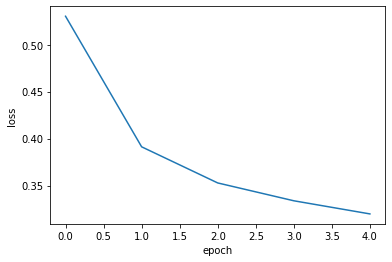

In [6]:
# 손실
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

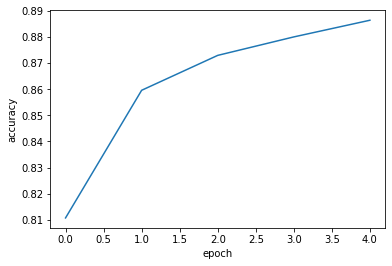

In [7]:
# 정확도
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### 더 많은 에포크

In [8]:
# 에포크 횟수를 20으로 늘려서 모델을 훈련
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

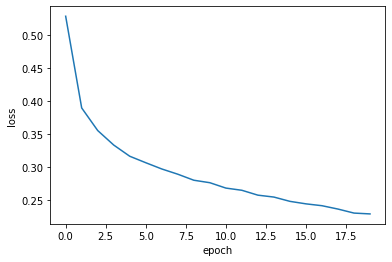

In [9]:
# 손실
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

### 검증 손실

In [10]:
# 에포크마다 검증 손실도 계산
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [11]:
# 훈련 세트에 대한 손실, 정확도, 검증 세트에 대한 손실, 정확도
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


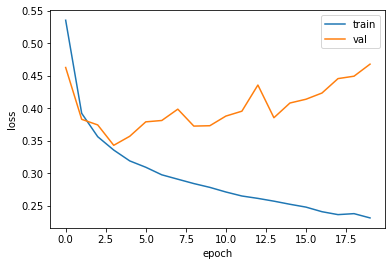

In [12]:
# 훈련 손실과 검증 손실
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭아웃

### 드롭아웃

In [13]:
# 30% 드롭아웃
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 옵티마이저 하이퍼파라미터를 적응적 학습률을 사용하는 Adam을 사용해 과대적합을 완화
# 에포크마다 검증 손실도 계산
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

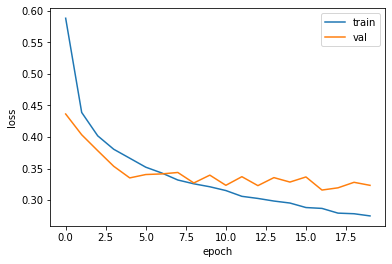

In [15]:
# 훈련 손실과 검증 손실
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원

### 모델 저장과 복원

In [16]:
# 에포크 횟수를 10으로 다시 지정하고 모델 훈련
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [17]:
# 모델의 파라미터를 저장
model.save_weights('model-weights.h5')

In [18]:
# 모델 구조와 모델 파라미터를 함께 저장
model.save('model-whole.h5')

In [19]:
# (1) 훈련을 하지 않은 새로운 모델을 만들고 mode-weights.h5 파일에서 훈련된 모델 파라미터 읽어서 사용
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [20]:
# 모델의 검증 정확도 확인
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.88


In [21]:
# (2) model_whole.h5 파일에서 새로운 모델을 만들어 바로 사용
# 모델 구조와 모델 파라미터를 함께 저장된 파일을 읽기
# (1)과 (2)는 같은 모델을 저장하고 다시 불렀기 때문에 동일한 정확도
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3334 - accuracy: 0.8800


[0.3333868682384491, 0.8799999952316284]

## 콜백

### 콜백

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# ModelCheckpoint 콜백을 사용해 best-model.h5에 최상의 검증 점수를 낸 모델 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [23]:
# best-model.h5에서 최상의 검증 점수를 낸 모델을 불러와 예측 수행
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8869


[0.3199754059314728, 0.8869166374206543]

### 조기종료

In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
# EarlyStopping 콜백을 사용해 검증 손실이 다시 상승할 때 훈련을 중지할 수 있음
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [27]:
# 훈련을 마치고 나면 몇 번째 에포크에서 훈련이 중지되었지 확인 가능
print(early_stopping_cb.stopped_epoch)

8


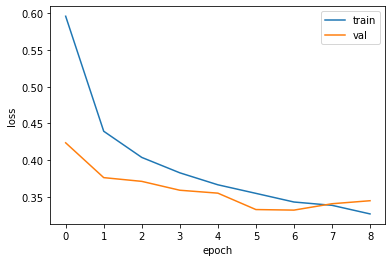

In [26]:
# 훈련 손실과 검증 손실
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [28]:
# 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능 확인
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3319 - accuracy: 0.8802


[0.3318639397621155, 0.8801666498184204]